<a href="https://colab.research.google.com/github/askuts/scoring-model/blob/main/scoring_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd

# Указываем путь к файлу XLSX
file_path = '/content/drive/MyDrive/fintech/fintech_dataset_v5.xlsx'

# Считываем данные из файла XLSX в объект DataFrame
data = pd.read_excel(file_path)

# Выводим первые несколько строк для проверки
print(data.head(3))

           сompany_name  success  employee_count  company_age_months  \
0  Paytm Payments Bank         0               4                75.0   
1              CashStar        1               1               116.0   
2                 Ebury        1               3               119.0   

   article_count  competition_intensity  product_count  \
0          232.0                    4.0           17.0   
1          156.0                    NaN            2.0   
2           87.0                   20.0            4.0   

   financing_rounds_count  investors_count total_investment_amount  ...  \
0                     3.0              3.0             $31,433,346  ...   
1                     1.0              7.0             $44,000,000  ...   
2                     1.0              8.0            $123,532,666  ...   

   scalability_reliability  intellectual_property_protection  \
0                      2.0                               0.0   
1                      2.0                       

In [ ]:
#проверяем типы данных и заполненность столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   сompany_name                             212 non-null    object 
 1   success                                  212 non-null    int64  
 2   employee_count                           212 non-null    int64  
 3   company_age_months                       208 non-null    float64
 4   article_count                            197 non-null    float64
 5   competition_intensity                    133 non-null    float64
 6   product_count                            196 non-null    float64
 7   financing_rounds_count                   208 non-null    float64
 8   investors_count                          207 non-null    float64
 9   total_investment_amount                  205 non-null    object 
 10  business_model                           210 non-n

In [ ]:
#меняем в столбцах 'total_investment_amount' запятые на точки  и преобразуем их в числовой  формат
for i in ['total_investment_amount']:
    data[i] = data[i].str.replace(',', '')
    data[i] = data[i].str.replace('$', '').astype('float')

# Удаляем столбец 'сompany_name' из DataFrame data
data.drop(columns=['сompany_name'], inplace=True)

#проверяем типы данных и заполненность столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   success                                  212 non-null    int64  
 1   employee_count                           212 non-null    int64  
 2   company_age_months                       208 non-null    float64
 3   article_count                            197 non-null    float64
 4   competition_intensity                    133 non-null    float64
 5   product_count                            196 non-null    float64
 6   financing_rounds_count                   208 non-null    float64
 7   investors_count                          207 non-null    float64
 8   total_investment_amount                  205 non-null    float64
 9   business_model                           210 non-null    float64
 10  monetization                             211 non-n

In [ ]:
# анализируем зависимую переменную: какие значения она принимает и сколько раз
data['success'].value_counts(dropna=False)

success
0    132
1     80
Name: count, dtype: int64

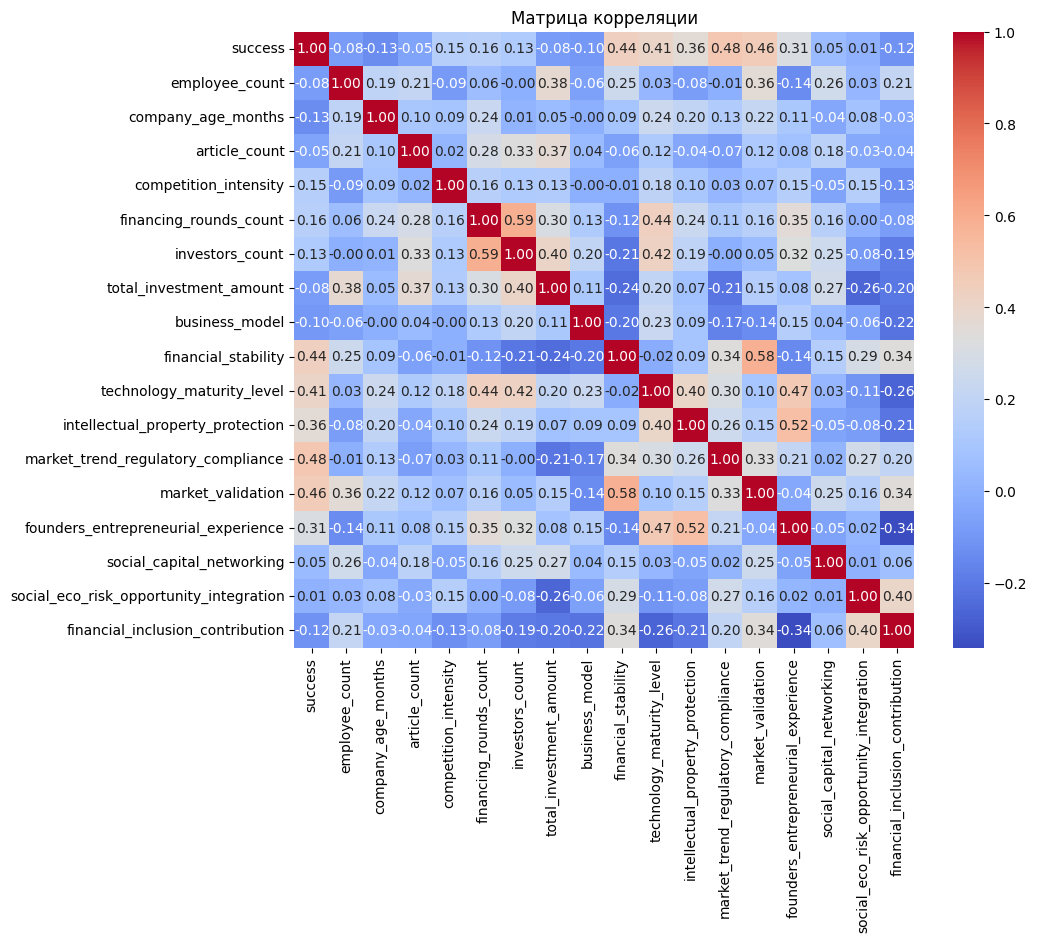

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Построение матрицы корреляции
correlation_matrix = data.corr()

# Создание тепловой карты (heatmap) для визуализации матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_score, recall_score, classification_report

# Разделение данных на признаки и целевую переменную
X = data.drop('success', axis=1)
y = data['success']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели XGBoost
xgb_model = XGBClassifier()

param_grid = {
    'base_estimator__n_estimators': [50, 70, 100],
    'base_estimator__learning_rate': [0.01, 0.1],
    'base_estimator__max_depth': [3, 5]
}

# Определение модели бэггинга с базовым классификатором XGBoost
bagging_model = BaggingClassifier(base_estimator=xgb_model, n_estimators=10, random_state=42)

# Поиск лучших параметров с кросс-валидацией
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_

# Оценка модели с использованием метрик ROC-AUC, Accuracy, Precision и Recall
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, grid_search.predict(X_test))
precision = precision_score(y_test, grid_search.predict(X_test))
recall = recall_score(y_test, grid_search.predict(X_test))

print("Best Parameters:", best_params)
print("ROC-AUC:", roc_auc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Best Parameters: {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 100}
ROC-AUC: 0.9422222222222223
Accuracy: 0.8837209302325582
Precision: 0.8095238095238095
Recall: 0.9444444444444444


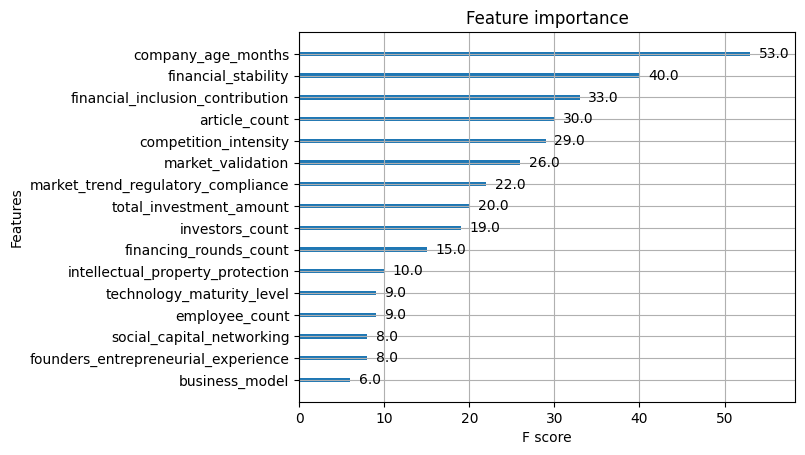

In [ ]:
# Далее визуализируем важности признаков модели
from xgboost import plot_importance

# Обучение модели XGBoost
xgb_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
# Визуализация важности признаков
plot_importance(xgb_model)
plt.show()

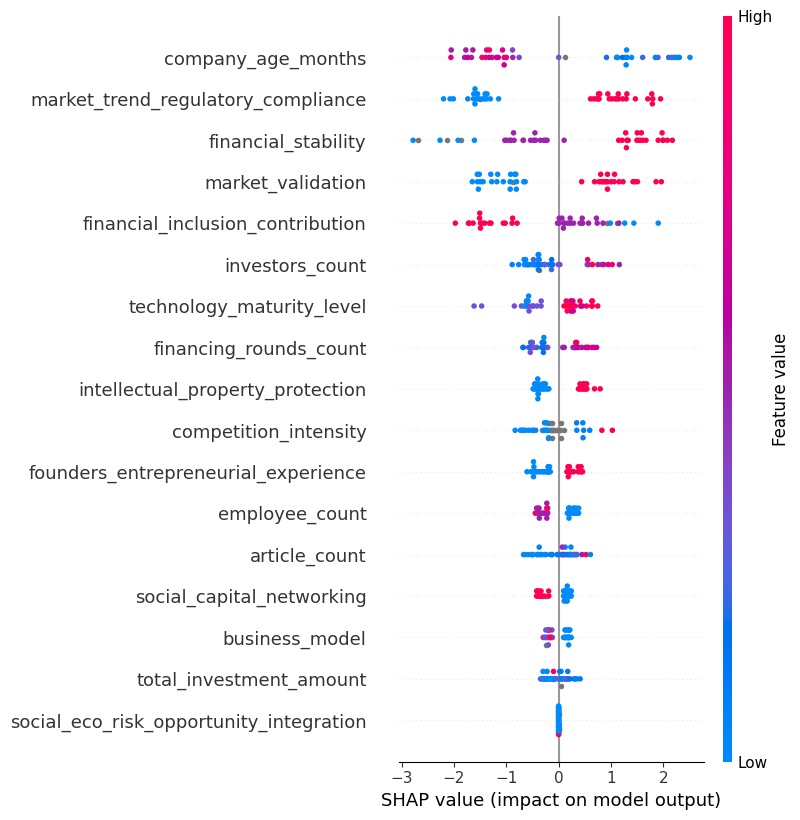

In [ ]:
# Создание объекта explainer для модели XGBoost
explainer = shap.Explainer(xgb_model)

# Рассчет SHAP значений для тестового набора данных
shap_values = explainer.shap_values(X_test)

# Вывод summary plot для оценки важности признаков и взаимодействия между ними
shap.summary_plot(shap_values, X_test)

In [ ]:
data.drop(columns=['target_market_volume_growth',
                   'social_capital_networking', 'social_eco_risk_opportunity_integration'], inplace=True)

In [ ]:
# Разделение данных на признаки и целевую переменную
X = data.drop('success', axis=1)
y = data['success']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение модели XGBoost
xgb_model = XGBClassifier()

param_grid = {
    'base_estimator__n_estimators': [50, 70, 100],
    'base_estimator__learning_rate': [0.01, 0.1],
    'base_estimator__max_depth': [3, 5]
}

# Определение модели бэггинга с базовым классификатором XGBoost
bagging_model = BaggingClassifier(base_estimator=xgb_model, n_estimators=10, random_state=42)

# Поиск лучших параметров с кросс-валидацией
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_

# Оценка модели с использованием метрик ROC-AUC, Accuracy, Precision и Recall
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, grid_search.predict(X_test))
precision = precision_score(y_test, grid_search.predict(X_test))
recall = recall_score(y_test, grid_search.predict(X_test))

print("Best Parameters:", best_params)
print("ROC-AUC:", roc_auc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Best Parameters: {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 5, 'base_estimator__n_estimators': 100}
ROC-AUC: 0.8355555555555556
Accuracy: 0.7674418604651163
Precision: 0.7
Recall: 0.7777777777777778


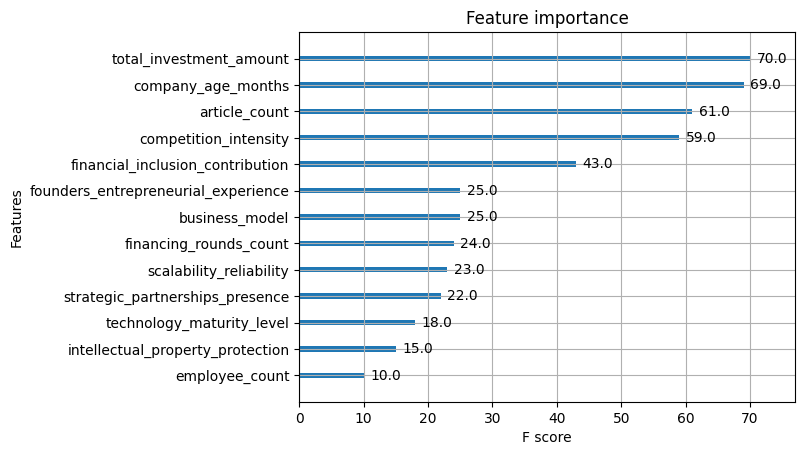

In [ ]:
# Далее визуализируем важности признаков модели
from xgboost import plot_importance

# Обучение модели XGBoost
xgb_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
# Визуализация важности признаков
plot_importance(xgb_model)
plt.show()

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.4 MB/s eta 0:00:00


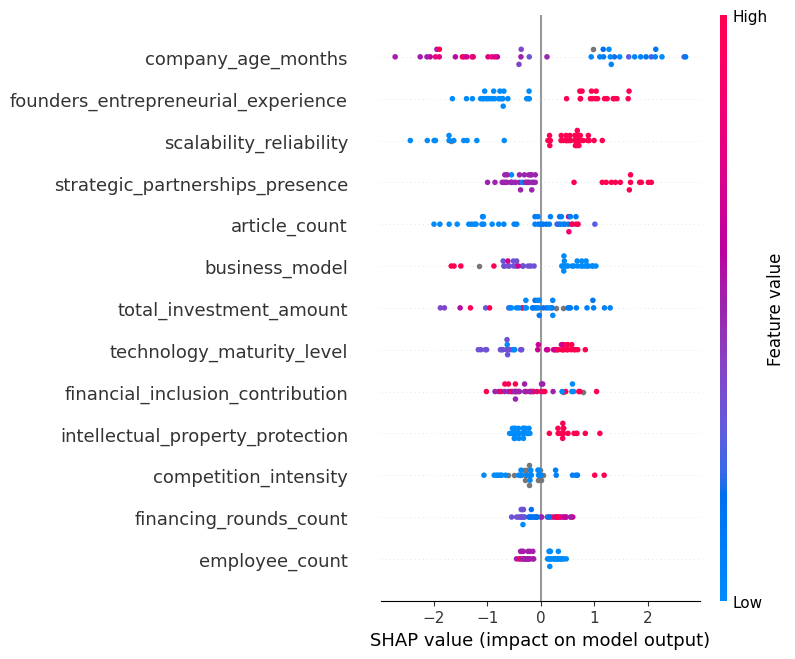

In [ ]:
# Создание объекта explainer для модели XGBoost
explainer = shap.Explainer(xgb_model)

# Рассчет SHAP значений для тестового набора данных
shap_values = explainer.shap_values(X_test)

# Вывод summary plot для оценки важности признаков и взаимодействия между ними
shap.summary_plot(shap_values, X_test)